In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv('Data/Little_Rock_Police_Department_Statistics_2017_to_Year_to_Date_20240926.csv')

In [5]:
df.head()

INCIDENT_DATE INCIDENT_NUMBER  LOCATION_DISTRICT OFFENSE_CODE  \
0  03/13/2023 02:01:00 PM     2023-028474               71.0          220   
1  07/14/2022 07:01:00 PM     2022-083175               52.0          23G   
2  02/05/2021 04:22:00 PM     2021-011014               82.0          23H   
3  05/25/2022 04:11:00 PM     2022-060552               52.0          220   
4  09/06/2022 06:24:00 PM     2022-106453               42.0          220   

            OFFENSE_DESCRIPTION WEAPON_TYPE INCIDENT_LOCATION         CITY  \
0                  BURGLARY/B&E         NaN  123  FALSTONE DR  LITTLE ROCK   
1  THEFT OF MOTOR VEHICLE PARTS         NaN    1900 W 17TH ST  LITTLE ROCK   
2             ALL OTHER LARCENY         NaN      30  HOGAN DR  LITTLE ROCK   
3                  BURGLARY/B&E         NaN    2704 S ARCH ST  LITTLE ROCK   
4                  BURGLARY/B&E         NaN    2017  BOYCE ST  LITTLE ROCK   

  STATE      ZIP   LATITUDE  LONGITUDE               Location 1 Offense Status  
0    AR  72223.0        NaN        NaN                      NaN             OP  
1    AR  72114.0        NaN        NaN                      NaN             OP  
2    AR  72209.0  34.467020 -92.231541   (34.46702, -92.231541)             OP  
3    AR  72201.0  34.472225 -92.228048  (34.472225, -92.228048)             OP  
4    AR  72202.0  34.472733 -92.225025  (34.472733, -92.225025)             EX

In [61]:
# Convert columns to datetime format

df['INCIDENT_DATE_CONVERTED'] = pd.to_datetime(df['INCIDENT_DATE'], format='%m/%d/%Y %I:%M:%S %p')
df['Year'] = df['INCIDENT_DATE_CONVERTED'].dt.year
df['Month'] = df['INCIDENT_DATE_CONVERTED'].dt.month
df['Day'] = df['INCIDENT_DATE_CONVERTED'].dt.day
df['Hour'] = df['INCIDENT_DATE_CONVERTED'].dt.hour

In [65]:
df.head()

INCIDENT_DATE INCIDENT_NUMBER  LOCATION_DISTRICT OFFENSE_CODE  \
0  03/13/2023 02:01:00 PM     2023-028474               71.0          220   
1  07/14/2022 07:01:00 PM     2022-083175               52.0          23G   
2  02/05/2021 04:22:00 PM     2021-011014               82.0          23H   
3  05/25/2022 04:11:00 PM     2022-060552               52.0          220   
4  09/06/2022 06:24:00 PM     2022-106453               42.0          220   

            OFFENSE_DESCRIPTION WEAPON_TYPE INCIDENT_LOCATION         CITY  \
0                  BURGLARY/B&E         NaN  123  FALSTONE DR  LITTLE ROCK   
1  THEFT OF MOTOR VEHICLE PARTS         NaN    1900 W 17TH ST  LITTLE ROCK   
2             ALL OTHER LARCENY         NaN      30  HOGAN DR  LITTLE ROCK   
3                  BURGLARY/B&E         NaN    2704 S ARCH ST  LITTLE ROCK   
4                  BURGLARY/B&E         NaN    2017  BOYCE ST  LITTLE ROCK   

  STATE      ZIP   LATITUDE  LONGITUDE               Location 1  \
0    AR  72223.0        NaN        NaN                      NaN   
1    AR  72114.0        NaN        NaN                      NaN   
2    AR  72209.0  34.467020 -92.231541   (34.46702, -92.231541)   
3    AR  72201.0  34.472225 -92.228048  (34.472225, -92.228048)   
4    AR  72202.0  34.472733 -92.225025  (34.472733, -92.225025)   

  Offense Status INCIDENT_DATE_CONVERTED  Year  Month  Day  Hour  
0             OP     2023-03-13 14:01:00  2023      3   13    14  
1             OP     2022-07-14 19:01:00  2022      7   14    19  
2             OP     2021-02-05 16:22:00  2021      2    5    16  
3             OP     2022-05-25 16:11:00  2022      5   25    16  
4             EX     2022-09-06 18:24:00  2022      9    6    18

In [11]:
df.columns

Index(['INCIDENT_DATE', 'INCIDENT_NUMBER', 'LOCATION_DISTRICT', 'OFFENSE_CODE',
       'OFFENSE_DESCRIPTION', 'WEAPON_TYPE', 'INCIDENT_LOCATION', 'CITY',
       'STATE', 'ZIP', 'LATITUDE', 'LONGITUDE', 'Location 1', 'Offense Status',
       'INCIDENT_DATE_CONVERTED', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')

In [73]:
crime_clean = df.dropna(subset=['LATITUDE', 'LONGITUDE'])

In [75]:
crime_clean.head()

INCIDENT_DATE INCIDENT_NUMBER  LOCATION_DISTRICT OFFENSE_CODE  \
2   02/05/2021 04:22:00 PM     2021-011014               82.0          23H   
3   05/25/2022 04:11:00 PM     2022-060552               52.0          220   
4   09/06/2022 06:24:00 PM     2022-106453               42.0          220   
21  02/04/2018 02:40:00 PM     2018-014490               82.0          23C   
22  11/09/2020 04:11:00 PM     2020-131671               91.0          240   

    OFFENSE_DESCRIPTION WEAPON_TYPE     INCIDENT_LOCATION         CITY STATE  \
2     ALL OTHER LARCENY         NaN          30  HOGAN DR  LITTLE ROCK    AR   
3          BURGLARY/B&E         NaN        2704 S ARCH ST  LITTLE ROCK    AR   
4          BURGLARY/B&E         NaN        2017  BOYCE ST  LITTLE ROCK    AR   
21          SHOPLIFTING         NaN     5609  BASELINE RD  LITTLE ROCK    AR   
22  MOTOR VEHICLE THEFT         NaN  11500  CHICOT RD 135  LITTLE ROCK    AR   

        ZIP   LATITUDE  LONGITUDE               Location 1 Offense Status  \
2   72209.0  34.467020 -92.231541   (34.46702, -92.231541)             OP   
3   72201.0  34.472225 -92.228048  (34.472225, -92.228048)             OP   
4   72202.0  34.472733 -92.225025  (34.472733, -92.225025)             EX   
21  72209.0  34.668970 -92.340067   (34.66897, -92.340067)             OP   
22  72103.0  34.646316 -92.368454  (34.646316, -92.368454)             OP   

   INCIDENT_DATE_CONVERTED  Year  Month  Day  Hour  
2      2021-02-05 16:22:00  2021      2    5    16  
3      2022-05-25 16:11:00  2022      5   25    16  
4      2022-09-06 18:24:00  2022      9    6    18  
21     2018-02-04 14:40:00  2018      2    4    14  
22     2020-11-09 16:11:00  2020     11    9    16

In [77]:
crime_filtered = crime_clean[crime_clean['Year'] !=2024]
# exclude data from 2024

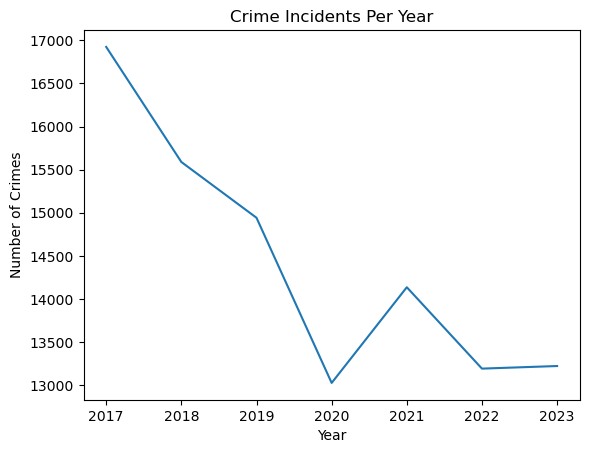

In [19]:
# plot crimes per year

crime_filtered.groupby('Year').size().plot(kind='line')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.title('Crime Incidents Per Year')
plt.show()

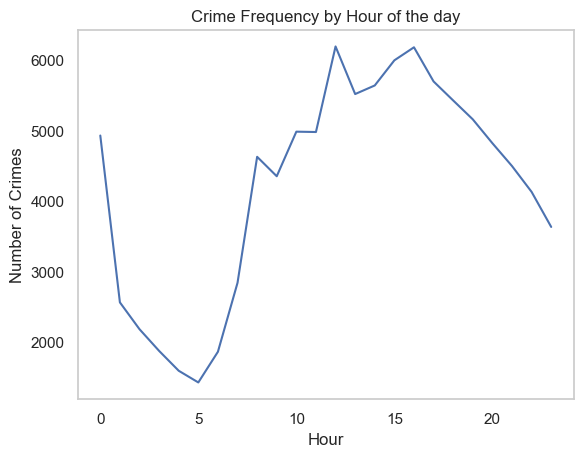

In [83]:
# plot crimes by hour 

crime_filtered.groupby('Hour').size().plot(kind='line')
plt.xlabel('Hour')
plt.ylabel('Number of Crimes')
plt.title('Crime Frequency by Hour of the day')
plt.grid(False)
plt.show()

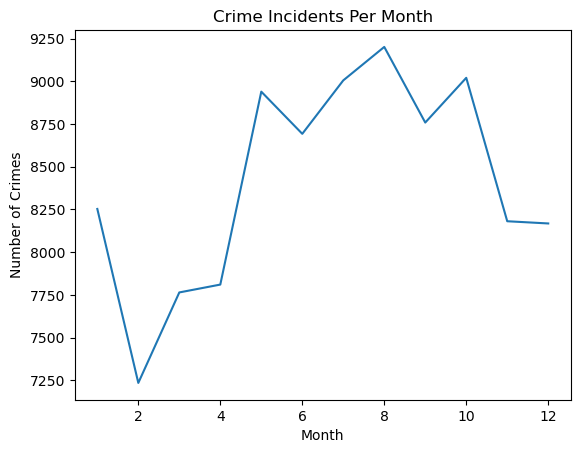

In [23]:
# plot crimes by month

crime_filtered.groupby('Month').size().plot(kind='line')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.title('Crime Incidents Per Month')
plt.show()

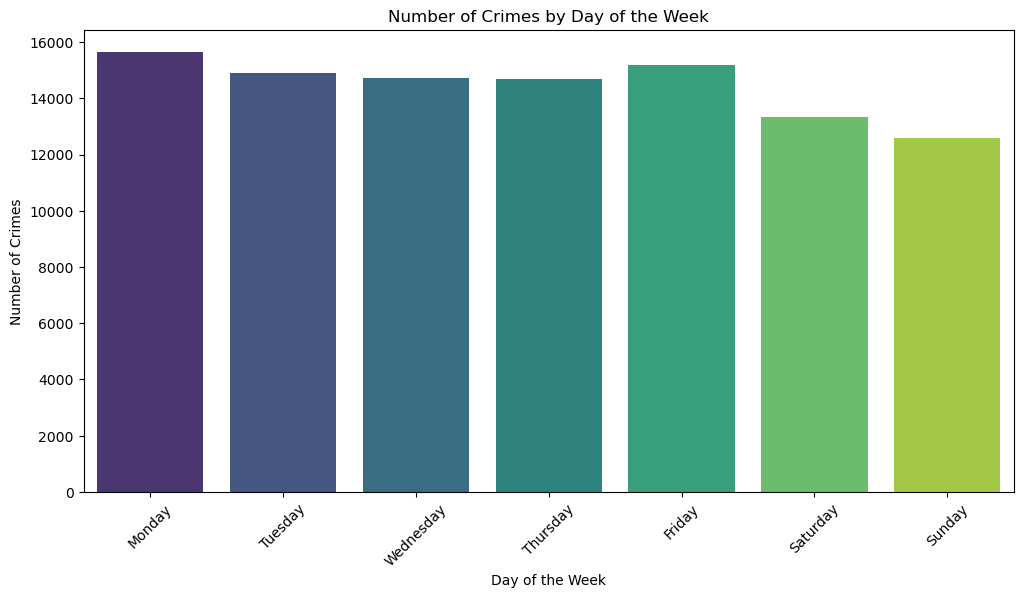

In [27]:
# crime by day
crime_filtered.loc[:, 'day_of_week']= crime_filtered['INCIDENT_DATE_CONVERTED'].dt.day_name()
crime_by_day = crime_filtered.groupby('day_of_week').size().reset_index(name='Count')

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
crime_by_day['day_of_week'] = pd.Categorical(crime_by_day['day_of_week'], categories=day_order, ordered=True)
crime_by_day = crime_by_day.sort_values('day_of_week')

plt.figure(figsize=(12,6))
sns.barplot(x='day_of_week', y='Count', data=crime_by_day, palette='viridis', hue='day_of_week', legend=False)

plt.title('Number of Crimes by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.show()

In [29]:
# analyze crime types
crime_counts = crime_filtered['OFFENSE_DESCRIPTION'].value_counts().reset_index()
crime_counts.columns = ['Crime Type', 'Count']

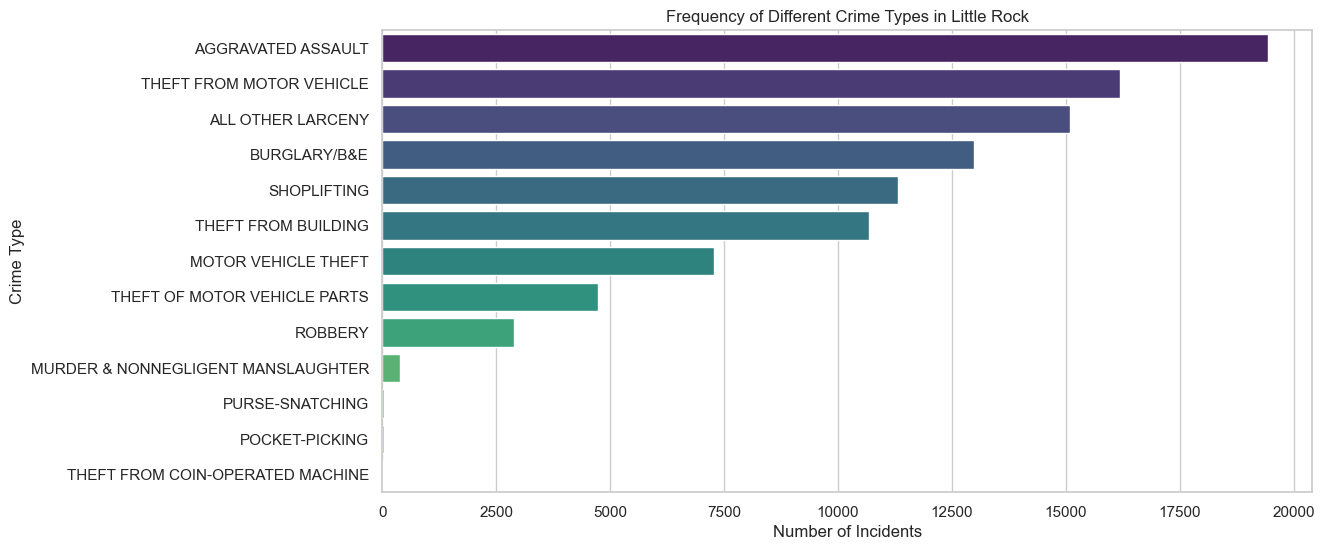

In [31]:
# visualize crime types
sns.set(style='whitegrid')

plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Crime Type', data=crime_counts, palette= 'viridis', hue='Crime Type', legend=False)
plt.title('Frequency of Different Crime Types in Little Rock')
plt.xlabel('Number of Incidents')
plt.ylabel('Crime Type')
plt.show()

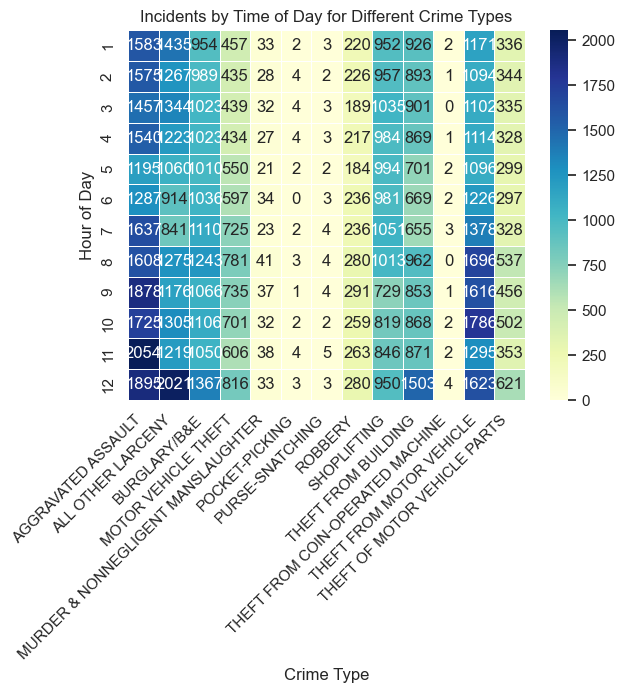

In [33]:
# analyze crime types by time of day
hourly_crime = crime_filtered.groupby(['Hour', 'OFFENSE_DESCRIPTION']).size().reset_index(name='count')
# pivot the df so hours are rows and crime types are columns
heatmap_data = hourly_crime.pivot(index='Hour', columns='OFFENSE_DESCRIPTION', values='count').fillna(0) 

# visualize in heatmap
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='.0f', linewidths=0.5)

plt.title('Incidents by Time of Day for Different Crime Types')
plt.xlabel('Crime Type')
plt.ylabel('Hour of Day')
plt.xticks(rotation=45, ha='right')
plt.show()

In [35]:
# geospatial analysis

geometry = [Point(xy) for xy in zip(crime_filtered['LONGITUDE'], crime_filtered['LATITUDE'])]
geo_crime_data = gpd.GeoDataFrame(crime_filtered, geometry=geometry)
geo_crime_data.crs = 'EPSG:4326' # setting the coordinate reference system to WGS84

In [36]:
# heat map
map_center = [geo_crime_data['LATITUDE'].mean(), geo_crime_data['LONGITUDE'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

heat_data=[[row['LATITUDE'], row['LONGITUDE']] for index, row in geo_crime_data.iterrows()]

HeatMap(heat_data, radius=10, blur=7).add_to(m)
m

In [39]:
# heat map of aggravated assault only
filtered_crime = crime_filtered[crime_filtered['OFFENSE_DESCRIPTION']=='AGGRAVATED ASSAULT']

In [41]:
m = folium.Map(location=[filtered_crime['LATITUDE'].mean(), filtered_crime['LONGITUDE'].mean()], zoom_start=12)

heated_data = [[row['LATITUDE'], row['LONGITUDE']] for index, row in filtered_crime.iterrows()]
HeatMap(heat_data, radius=15).add_to(m)
m


In [43]:
# heat map of motor vehicle theft only
filtered_crime2 = crime_filtered[crime_filtered['OFFENSE_DESCRIPTION']=='MOTOR VEHICLE THEFT']

m = folium.Map(location=[filtered_crime2['LATITUDE'].mean(), filtered_crime2['LONGITUDE'].mean()], zoom_start=12)

heated_data = [[row['LATITUDE'], row['LONGITUDE']] for index, row in filtered_crime2.iterrows()]
HeatMap(heat_data, radius=15).add_to(m)
m

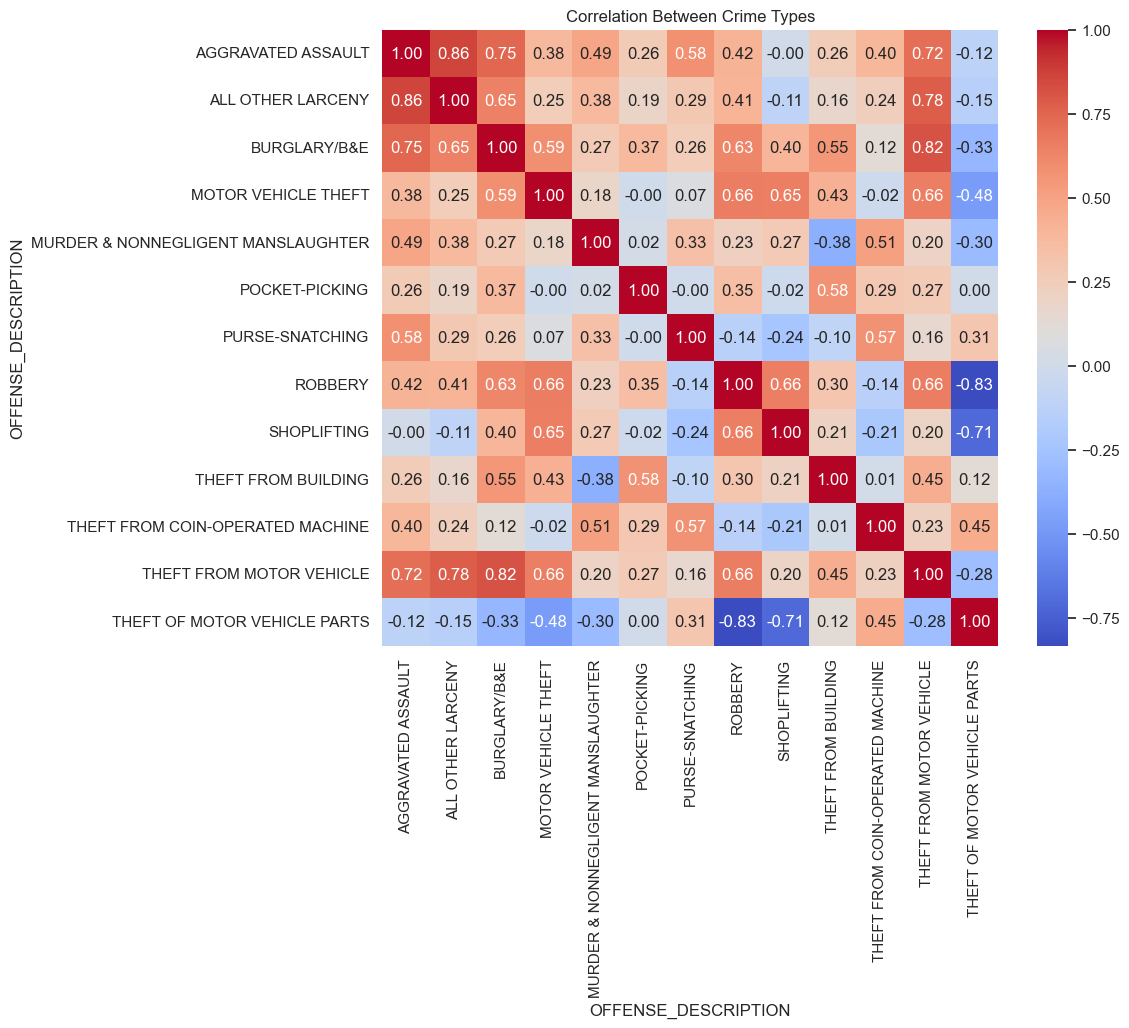

In [45]:
# Pivot the DataFrame to create a matrix of crime types by month (or day, or any other time frame)
crime_counts = crime_filtered['OFFENSE_DESCRIPTION'].value_counts().reset_index()
crime_counts.columns = ['OFFENSE_DESCRIPTION', 'Count']

# Pivot to create a correlation matrix
crime_pivot = crime_filtered.pivot_table(index='Month', columns='OFFENSE_DESCRIPTION', values='INCIDENT_DATE_CONVERTED', aggfunc='count', fill_value=0)

# Calculate the correlation matrix
correlation_matrix = crime_pivot.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Between Crime Types')
plt.show()

In [47]:
# regression analysis
crime_counts = crime_filtered.groupby(['Hour', 'Day']).size().reset_index(name='Incident_Count')

X = crime_counts[['Hour', 'Day']] 
y = crime_counts['Incident_Count']          

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         Incident_Count   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     86.43
Date:                Fri, 27 Sep 2024   Prob (F-statistic):           1.64e-31
Time:                        15:19:49   Log-Likelihood:                -1885.5
No. Observations:                 372   AIC:                             3777.
Df Residuals:                     369   BIC:                             3789.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        243.9472      5.572     43.784      0.0